In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *



In [ ]:
h5 = '../cerberus_annot.h5'
h5_annot = 'cerberus_annot_triplets.h5'
h5_annot_mouse = '../../../mouse/lr_bulk/triplets/cerberus_annot_triplets.h5'
swan_file = '../swan/swan.p'
mouse_swan_file = '../../../mouse/lr_bulk/swan/swan.p'
ab = '../../talon/human_talon_abundance.tsv'
mouse_filt_ab = '../../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
major_set_mouse = '../swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig3/'


In [ ]:
ca = cerberus.read(h5_annot)

## calculate distance of each gene / sample pair to its centroid

In [1]:
def get_human_df(ca):
    # compute centroid for each  sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [5]:
# centroids for each gene
cent_df = get_human_df(ca)
cent_df.loc[cent_df.gname=='BRK1']

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sector,gid_stable,biotype
1879,BRK1,ENSG00000254999,0.230769,0.461538,0.307692,3.8,mixed,ENSG00000254999,protein_coding


In [ ]:
# individual genes
source = 'sample_det'
df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso', 'sample', 'gene_tpm']
df = df[keep_cols]
df = assign_sector(df)

# only protein coding genes
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
gene_df = gene_df[['gid_stable', 'biotype']]
df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
df = df.loc[df.biotype=='protein_coding']

In [ ]:
df = df.merge(cent_df, how='left', on=['gname', 'gid'], suffixes=('', '_gene_avg'))

In [ ]:
len(df.index)

545554

In [ ]:
df.head()

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg
0,TSPAN6,ENSG00000000003,0.125000,0.625000,0.250000,18.0,caco2,347.757385,tes,ENSG00000000003,protein_coding,0.164188,0.590456,0.245356,8.560976,tes,ENSG00000000003,protein_coding
1,DPM1,ENSG00000000419,0.121951,0.487805,0.390244,11.0,caco2,126.812943,mixed,ENSG00000000419,protein_coding,0.168068,0.277963,0.553969,6.960000,splicing,ENSG00000000419,protein_coding
2,SCYL3,ENSG00000000457,0.200000,0.400000,0.400000,4.0,caco2,10.705085,mixed,ENSG00000000457,protein_coding,0.273306,0.389927,0.336767,2.250000,mixed,ENSG00000000457,protein_coding
3,C1orf112,ENSG00000000460,0.400000,0.200000,0.400000,4.0,caco2,17.822382,mixed,ENSG00000000460,protein_coding,0.361802,0.334081,0.304117,3.413043,mixed,ENSG00000000460,protein_coding
4,FUCA2,ENSG00000001036,0.135135,0.540541,0.324324,11.0,caco2,261.958191,tes,ENSG00000001036,protein_coding,0.168460,0.434446,0.397094,7.142857,mixed,ENSG00000001036,protein_coding


In [12]:
# compute distances
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist,
                               args=('', '_gene_avg'),
                               axis=1)
df.dist = df.dist.fillna(0)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js

In [13]:
df.head()

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist
0,TSPAN6,ENSG00000000003,0.125000,0.625000,0.250000,18.0,caco2,347.757385,tes,ENSG00000000003,protein_coding,0.164188,0.590456,0.245356,8.560976,tes,ENSG00000000003,protein_coding,0.039850
1,DPM1,ENSG00000000419,0.121951,0.487805,0.390244,11.0,caco2,126.812943,mixed,ENSG00000000419,protein_coding,0.168068,0.277963,0.553969,6.960000,splicing,ENSG00000000419,protein_coding,0.153413
2,SCYL3,ENSG00000000457,0.200000,0.400000,0.400000,4.0,caco2,10.705085,mixed,ENSG00000000457,protein_coding,0.273306,0.389927,0.336767,2.250000,mixed,ENSG00000000457,protein_coding,0.065119
3,C1orf112,ENSG00000000460,0.400000,0.200000,0.400000,4.0,caco2,17.822382,mixed,ENSG00000000460,protein_coding,0.361802,0.334081,0.304117,3.413043,mixed,ENSG00000000460,protein_coding,0.110722
4,FUCA2,ENSG00000001036,0.135135,0.540541,0.324324,11.0,caco2,261.958191,tes,ENSG00000001036,protein_coding,0.168460,0.434446,0.397094,7.142857,mixed,ENSG00000001036,protein_coding,0.075143


In [14]:
df.to_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t', index=False)

## Results

In [15]:
df = pd.read_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t')
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


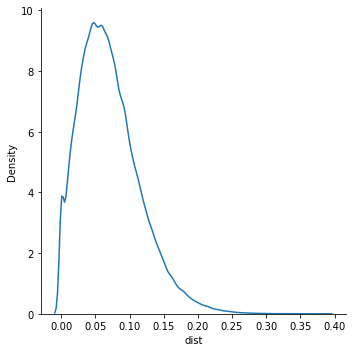

In [16]:
sns.displot(data=df, x='dist', kind='kde')

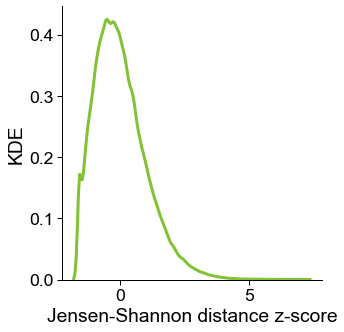

In [36]:
# calc z scores and use these to quantiy
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
df['z_score'] = st.zscore(df.dist.tolist())

ax = sns.displot(data=df, x='z_score', kind='kde', linewidth=3, color='#81c236')
xlabel = 'Jensen-Shannon distance z-score'
ylabel = 'KDE'
ax.set(xlabel=xlabel, ylabel=ylabel)
fname = '{}sample_det_vs_sample_det_centroid_zscore_dist.pdf'.format(fig_dir)
plt.savefig(fname, dpi=300)

In [17]:
# there were a bunch of genes w/ null dists which I changed to 0
temp = df.loc[df.dist.isnull()]
print(len(temp.index))
print(len(temp.loc[temp.tss_ratio == temp.tss_ratio_gene_avg].index))
temp.loc[temp.tss_ratio != temp.tss_ratio_gene_avg]

0
0


,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist,z_score


In [18]:
# ca.triplets.loc[(ca.triplets.gname=='PMS2P4')&(ca.triplets.source=='sample_det')]

In [19]:
len(df.loc[(df.z_score > 3), 'gid'].unique())

2896

In [37]:
df.loc[df.gname=='AKAP8L']

,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist,z_score
199,AKAP8L,ENSG00000011243,0.076923,0.076923,0.846154,11.0,caco2,93.390730,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.184464,2.571220
11775,AKAP8L,ENSG00000011243,0.055556,0.055556,0.888889,16.0,brain,99.171486,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.226684,3.524908
25521,AKAP8L,ENSG00000011243,0.111111,0.111111,0.777778,7.0,mcf10a,70.682960,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.124938,1.226599
36171,AKAP8L,ENSG00000011243,0.071429,0.071429,0.857143,12.0,a673,100.674330,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.194871,2.806303
47568,AKAP8L,ENSG00000011243,0.090909,0.181818,0.727273,12.0,lung,47.650883,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.090298,0.444120
62015,AKAP8L,ENSG00000011243,0.333333,0.333333,0.333333,1.0,hl60_m0,9.480823,simple,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.207206,3.084924
71524,AKAP8L,ENSG00000011243,0.111111,0.111111,0.777778,7.0,colon,55.193920,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.124938,1.226599
84995,AKAP8L,ENSG00000011243,0.111111,0.111111,0.777778,7.0,hmec,57.099216,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.124938,1.226599
95905,AKAP8L,ENSG00000011243,0.142857,0.142857,0.714286,5.0,k562,82.274010,splicing,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.076266,0.127157
106487,AKAP8L,ENSG00000011243,0.285714,0.285714,0.428571,6.0,imr90,72.334230,mixed,ENSG00000011243,protein_coding,0.163568,0.216477,0.619955,6.58,splicing,ENSG00000011243,protein_coding,0.139942,1.565516


In [20]:
# look for genes that are 
# - in the 16 cell lines
# - TFs? 
# - high z-score
ljungman_datasets = get_sample_datasets(sample='ljungman', groupby='sample')
df.loc[(df.z_score > 3)&(df['sample'].isin(ljungman_datasets))].sort_values(by='z_score', ascending=False).head(20)


,gname,gid,tss_ratio,tes_ratio,spl_ratio,n_iso,sample,gene_tpm,sector,gid_stable,biotype,tss_ratio_gene_avg,tes_ratio_gene_avg,spl_ratio_gene_avg,n_iso_gene_avg,sector_gene_avg,gid_stable_gene_avg,biotype_gene_avg,dist,z_score
32897,CTNNB1,ENSG00000168036,0.111111,0.111111,0.777778,7.0,mcf10a,76.340820,splicing,ENSG00000168036,protein_coding,0.405801,0.309722,0.284477,11.740000,mixed,ENSG00000168036,protein_coding,0.358551,6.503623
112232,SIDT2,ENSG00000149577,0.125000,0.125000,0.750000,6.0,imr90,132.612750,splicing,ENSG00000149577,protein_coding,0.373101,0.361839,0.265060,4.000000,mixed,ENSG00000149577,protein_coding,0.350336,6.318072
271544,DBF4,ENSG00000006634,0.111111,0.111111,0.777778,7.0,huvec,29.571903,splicing,ENSG00000006634,protein_coding,0.292082,0.405976,0.301941,6.208333,mixed,ENSG00000006634,protein_coding,0.346405,6.229277
519917,DPP7,ENSG00000176978,0.461538,0.230769,0.307692,2.0,hepg2,2.325026,mixed,ENSG00000176978,protein_coding,0.136518,0.088197,0.775284,19.000000,splicing,ENSG00000176978,protein_coding,0.339588,6.075287
2580,C17orf75,ENSG00000108666,0.166667,0.166667,0.666667,4.0,caco2,48.730656,splicing,ENSG00000108666,protein_coding,0.277786,0.498898,0.223315,4.700000,mixed,ENSG00000108666,protein_coding,0.328879,5.833373
275875,SRRM1,ENSG00000133226,0.071429,0.071429,0.857143,12.0,huvec,77.752750,splicing,ENSG00000133226,protein_coding,0.191116,0.369284,0.439600,10.580000,mixed,ENSG00000133226,protein_coding,0.321677,5.670686
34162,IST1,ENSG00000182149,0.111111,0.111111,0.777778,7.0,mcf10a,107.945880,splicing,ENSG00000182149,protein_coding,0.335937,0.326099,0.337965,11.100000,mixed,ENSG00000182149,protein_coding,0.318986,5.609903
89921,FGF2,ENSG00000138685,0.137255,0.823529,0.039216,6.0,hmec,41.009720,tes,ENSG00000138685,protein_coding,0.299994,0.423923,0.276083,1.730769,mixed,ENSG00000138685,protein_coding,0.313296,5.481379
398700,RGL2,ENSG00000237441,0.125000,0.125000,0.750000,6.0,ocily7,47.322968,splicing,ENSG00000237441,protein_coding,0.492805,0.155198,0.351997,6.088889,mixed,ENSG00000237441,protein_coding,0.310038,5.407780
113971,COL3A1,ENSG00000168542,0.041096,0.082192,0.876712,51.0,imr90,8789.470000,splicing,ENSG00000168542,protein_coding,0.182324,0.336280,0.481396,13.041667,mixed,ENSG00000168542,protein_coding,0.307697,5.354896


In [21]:
print(len(df.loc[(df.z_score > 3)].index))
print(len(df.loc[(df.z_score > 3), 'gname'].unique().tolist()))

5009
2896


In [38]:
n = len(df.index)
n_num = len(df.loc[df.z_score>3].index)
print('{:.2}% ({}/{}) gene /sample combos w/ zscore > 3'.format((n_num/n)*100, n_num, n))

0.92% (5009/545554) gene /sample combos w/ zscore > 3


In [39]:
temp = df.loc[df.z_score>3].copy(deep=True)
temp = temp[['gid', 'gname', 'sample']].groupby(['gid', 'gname']).nunique().reset_index().sort_values(by='sample', ascending=False)
temp.head(20)
len(temp.loc[temp['sample']>5].index)

57

## Are there samples that are reproducibly further from sample centroid?

In [17]:
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


In [18]:
df = pd.read_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t')

In [19]:
sns.set_context('paper', font_scale=2)
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

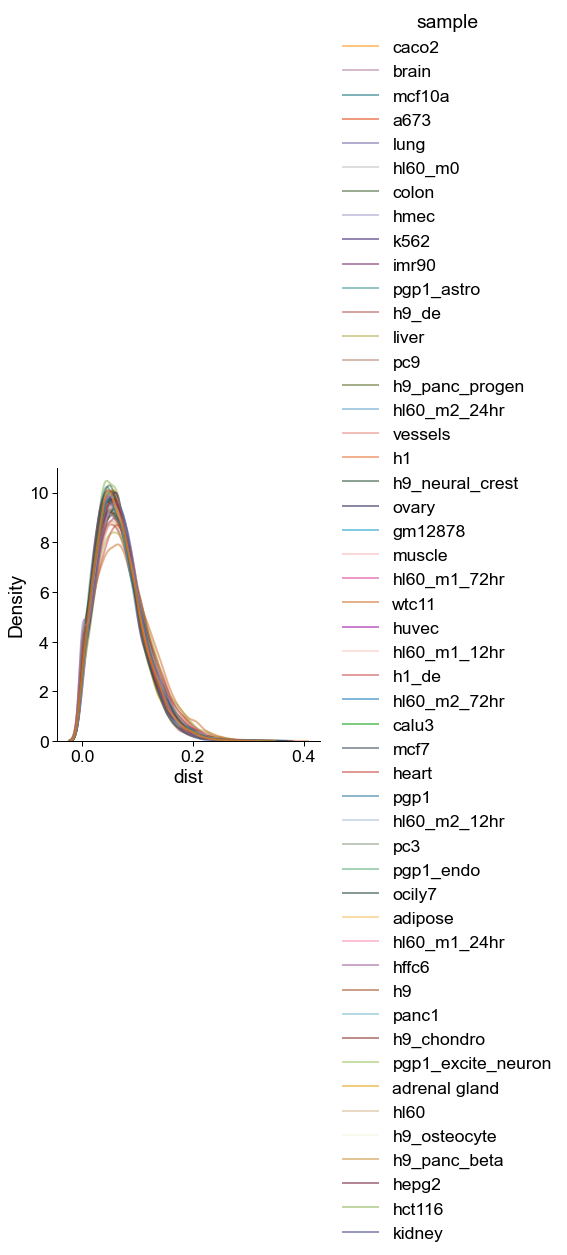

In [20]:
# plot dists for each sample
c_dict, order = get_biosample_colors()
sns.displot(df, x='dist', hue='sample',
            palette=c_dict,
            kind='kde', linewidth=2,
            alpha=0.5, 
            common_norm=False)

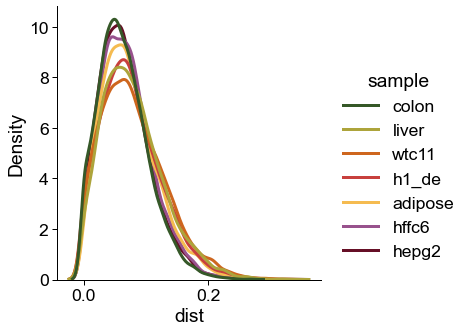

In [21]:
# plot dists for each sample
samples = ['wtc11', 'colon', 'hepg2', 'hffc6', 'adipose', 'liver', 'h1_de']
temp = df.loc[df['sample'].isin(samples)].copy(deep=True)
c_dict, order = get_biosample_colors()
sns.displot(temp, x='dist', hue='sample',
            palette=c_dict,
            kind='kde', linewidth=3,
            common_norm=False)

In [22]:
df = pd.read_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t')
c_dict, order = get_biosample_colors()

In [23]:
n = 2

temp2 = pd.DataFrame()
temp3 = pd.DataFrame()
for s in df['sample'].unique():
    
    # compute z-score dist for each sample
    temp = df.loc[df['sample'] == s]
    temp['sample_z_score'] = st.zscore(temp.dist.tolist())
    
    # which distance for this sample's z-score is > 2
    temp3 = pd.concat([temp3,
                       temp.loc[temp.sample_z_score > n].sort_values(by='sample_z_score',
                       ascending=True).head(1)[['sample', 'dist']]])    
    
    # add to parent
    temp = temp[['sample_z_score', 'sample', 'gid']]
    temp2 = pd.concat([temp2, temp], axis=0)

df = df.merge(temp2, how='left', on=['sample', 'gid'])

In [24]:
# sns.catplot(temp3, x='dist', hue='sample',
#             palette=c_dict, size=15)
# ax = plt.gca()
# sns.kdeplot(temp3, x='dist', ax=ax)

In [25]:
meta = pd.read_csv('../../swan/swan_metadata.tsv', sep='\t')
meta.head()
meta = meta[['sample', 'classification']].drop_duplicates()
temp3 = temp3.merge(meta, on='sample')


In [26]:
tc_c_dict, tc_order = get_tissue_cell_line_colors()

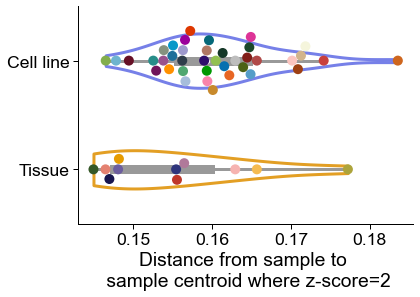

In [27]:
ax = sns.violinplot(temp3, x='dist', y='classification', order=tc_order,
                    linewidth=3, fillcolor=None, cut=0, width=0.5, color='w')
ax2 = sns.swarmplot(temp3, x='dist', y='classification', hue='classification', palette=tc_c_dict,
              order=tc_order, s=10)

first_c = True
for i in range(len(ax.collections)):
    if isinstance(ax.collections[i], mpl.collections.PolyCollection):
        if first_c:
            key = 'cell_line'
        else:
            key = 'tissue'
        c = tc_c_dict[key]
        ax.collections[i].set_edgecolor(c)  
        first_c = False
    
n_t = len(temp3.loc[temp3.classification=='tissue'].index)
n_c = len(temp3.loc[temp3.classification=='cell_line'].index)
d = {n_t: 'tissue', n_c: 'cell_line'}
for i in range(len(ax2.collections)):
    if isinstance(ax2.collections[i], mpl.collections.PathCollection):
        try: 
            cl = d[len(ax2.collections[i].properties()['facecolor'])]
        except: continue
        colors = [c_dict[c] for c in temp3.loc[temp3.classification==cl, 'sample'].tolist()]
        ax2.collections[i].set_color(colors)
ax.get_legend().remove()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

yticks = ['Cell line', 'Tissue']
ax.set(yticklabels=yticks, ylabel='', xlabel='Distance from sample to \n sample centroid where z-score=2')

fname = 'figures/sample_vs_sample_centroid_zscore_2_distance_dist.pdf'
plt.savefig(fname, dpi=700, bbox_inches='tight')

## % genes in each sector based on sample-det

In [28]:
ca = cerberus.read(h5_annot) 

In [29]:
df = ca.triplets.loc[ca.triplets.source=='sample_det']
df = assign_sector(df)

# get # of genes per sector / sample and % of genes in that sample
df = df[['gid', 'sample', 'sector']].groupby(['sample', 'sector']).count().reset_index()
df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
df2 = df[['sample', 'n_genes']].groupby('sample').sum().reset_index()
df2.rename({'n_genes': 'total_genes'}, axis=1, inplace=True)
df = df.merge(df2, on='sample')
df['perc'] = (df['n_genes']/df['total_genes'])*100

# add cell line / tissue metadat
meta = pd.read_csv('../../swan/swan_metadata.tsv', sep='\t')
meta.head()
meta = meta[['sample', 'classification']].drop_duplicates()
df = df.merge(meta, on='sample')

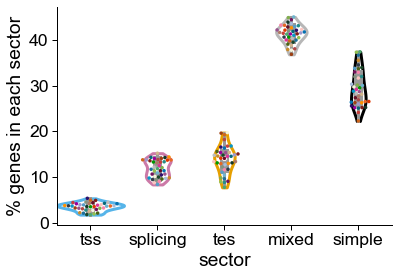

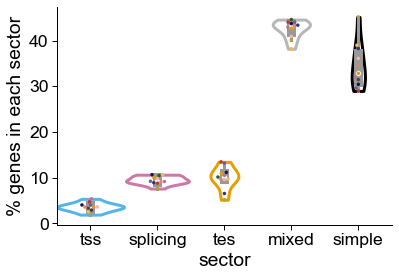

<Figure size 432x288 with 0 Axes>

In [30]:
c_dict, order = get_sector_colors()
s_dict, s_order = get_biosample_colors()
for c in df.classification.unique().tolist():
    temp = df.loc[df.classification==c]
    ax = sns.violinplot(data=temp, y='perc', x='sector',
                   order=order,
                   linewidth=3, fillcolor=None, cut=0, width=1, color='w')
    
    j = 0
    for i in range(len(ax.collections)):
        if isinstance(ax.collections[i], mpl.collections.PolyCollection):
            sector = order[j]
            j += 1
            sect_color = c_dict[sector]
            ax.collections[i].set_edgecolor(sect_color) 
            

    ax = sns.swarmplot(data=temp, y='perc', x='sector', hue='sector', order=order, s=3.5)
    j = 0
    lens = [len(df.loc[df.classification=='cell_line', 'sample'].unique().tolist()),
            len(df.loc[df.classification=='tissue', 'sample'].unique().tolist())]
    for i in range(len(ax.collections)):
        if isinstance(ax.collections[i], mpl.collections.PathCollection):
            # print(ax.collections[i].properties())
            if len(ax.collections[i].properties()['facecolor']) in lens:
                sector = order[j%len(order)]
                j+=1 
                colors = [s_dict[sample] for sample in df.loc[(df.classification==c)&(df.sector==sector), 'sample'].tolist()]
                ax.collections[i].set_color(colors)
        
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.get_legend().remove()
    
    # if sector in ['TSS', 'TES']: sector_hr = sector.upper()
    # else: sector_hr = sector.capitalize()
    ax.set_ylabel('% genes in each sector')
    
    # color outline of each violin by the sector
    plt.show()
    plt.clf()

## WTC11 stuff -- GO terms and some simplex plots

In [195]:
df = pd.read_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t')
c_dict, order = get_biosample_colors()

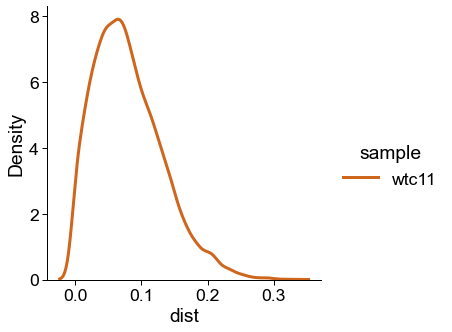

In [196]:
# plot dists for each sample
samples = ['wtc11']
temp = df.loc[df['sample'].isin(samples)].copy(deep=True)
c_dict, order = get_biosample_colors()
sns.displot(temp, x='dist', hue='sample',
            palette=c_dict,
            kind='kde', linewidth=3,
            common_norm=False)

In [197]:
df = df.loc[df['sample'] == 'wtc11']
df['z_score'] = st.zscore(df.dist.tolist())

In [198]:
z_score = 2
gids = df.loc[df.z_score > z_score, 'gid'].tolist()

In [199]:
# dbs = ['GO_Biological_Process_2021',
#        'GO_Cellular_Component_2021',
#        'GO_Molecular_Function_2021',
#        'KEGG_2021_Human']
# bm = gp.parser.Biomart()
# datasets = bm.get_datasets(mart='ENSEMBL_MART_ENSEMBL')
# datasets.loc[datasets.Description.str.contains('Human')]
# desc = 'WTC11 high-distance genes'
# odir = 'wtc11_sample_v_sample_det_dist_genes_GO'
# gids = bm.query(dataset='hsapiens_gene_ensembl',
#                 attributes=['ensembl_gene_id', 'external_gene_name'],
#                 filters={'ensembl_gene_id': gids})
# gids = gids.loc[~gids.external_gene_name.isna()]
# gnames = gids.external_gene_name.squeeze().str.strip().tolist()
# go = gp.enrichr(gene_list=gnames,
#                 gene_sets=dbs,
#                 organism='Human',
#                 description=desc,
#                 outdir=odir,
#                 cutoff=0.5)

In [200]:
# df.sort_values(by='dist', ascending=False).head(20)[['gname', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'tss_ratio_gene_avg', 'tes_ratio_gene_avg', 'spl_ratio_gene_avg']]

In [216]:
df.head()
temp1 = df[['gid', 'sector_gene_avg']] # sample avg.
temp1['source'] = 'Sample avg.'
temp1.rename({'sector_gene_avg': 'sector'}, axis=1, inplace=True)
n = len(temp1.index)
temp1 = temp1.groupby(['source', 'sector']).count().reset_index()
temp1.rename({'gid': 'n_genes'}, axis=1, inplace=True)
temp1['total'] = n
temp1['perc'] = (temp1.n_genes/temp1['total'])*100

temp2 = df[['gid', 'sector']]
temp2['source'] = 'WTC11'
n = len(temp2.index)
temp2 = temp2.groupby(['source', 'sector']).count().reset_index()
temp2.rename({'gid': 'n_genes'}, axis=1, inplace=True)
temp2['total'] = n
temp2['perc'] = (temp2.n_genes/temp2['total'])*100

temp = pd.concat([temp1, temp2], axis=0)

<Figure size 144x1440 with 0 Axes>

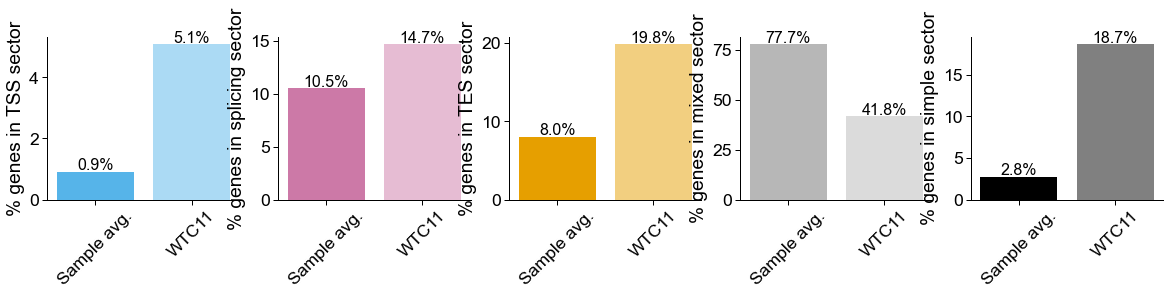

In [ ]:
cat1 = 'sector'
cat2 = 'source'
cat2_order = ['Sample avg.', 'WTC11']
cat1_order = ['tss', 'splicing', 'tes', 'mixed', 'simple']
parent_c_dict, parent_order = get_sector_colors()

sns.set_context('paper', font_scale=2)
plt.figure(figsize=(2,20))
fig, axes = plt.subplots(1, len(cat1_order), figsize=(20,3))

# loop through first category
for i, c1 in enumerate(cat1_order):
    # pdb.set_trace()
    beep = temp.loc[temp[cat1] == c1]

    c = parent_c_dict[c1]
    c_dict, order = get_shade_colors(c, cat2_order)

    # plotting
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42
    # plt.figure(figsize=(3,4))

    ax = sns.barplot(data=beep, y='perc', x=cat2,
                     palette=c_dict, order=order,
                     saturation=1, ax=axes[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    xlabel = ''
    if c1 in ['tss', 'tes']:
        c1 = c1.upper()
    ylabel = '% genes in {} sector'.format(c1)

    _ = ax.set(xlabel=xlabel, ylabel=ylabel)
    ax.tick_params(axis="x", rotation=45)    
    ax.set_xticklabels(cat2_order)

    def add_perc_2(ax):
        ylim = ax.get_ylim()[1]
        n_cats = len(ax.patches)
        for p in ax.patches:
            percentage = '{:.1f}%'.format(p.get_height())
            x = p.get_x() + p.get_width() / 2
            y = p.get_y() + p.get_height() + ylim*0.01
            ax.annotate(percentage, (x, y), size=16, horizontalalignment='center')

    add_perc_2(ax)
# plt.show()
# plt.subplots_adjust(wspace=0.35)
# plt.tight_layout()
plt.savefig(fname, dpi=500, layout='tight', bbox_inches="tight")


In [192]:
# sankey plot
df = df[['gid', 'sector', 'sector_gene_avg']]
df = df.groupby(['sector', 'sector_gene_avg']).count().reset_index()
df.rename({'gid': 'n_genes'}, axis=1, inplace=True)
df.head()

,sector,sector_gene_avg,n_genes
0,mixed,mixed,4826
1,mixed,splicing,254
2,mixed,tes,164
3,mixed,tss,24
4,simple,mixed,1952


{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}
{'label': ['TSS', 'Splicing', 'TES', 'Mixed', 'Simple', 'TSS', 'Splicing', 'TES', 'Mixed', 'Simple'], 'color': ['#56B4E9', '#CC79A7', '#E69F00', '#b7b7b7', '#000000', '#56B4E9', '#CC79A7', '#E69F00', '#b7b7b7', '#000000'], 'x': [0.01, 0.01, 0.01, 0.01, 0.01, 1.0, 1.0, 1.0, 1.0, 1.0], 'y': [0.01, 0.25, 0.5, 0.75, 1.0, 0.01, 0.25, 0.5, 0.75, 1.0]}


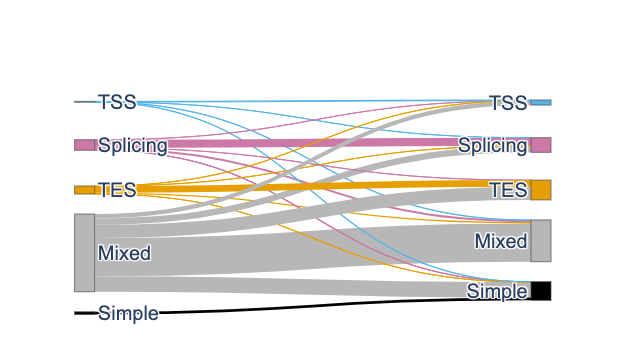

In [194]:
ofile = 'figures/wtc11_sample_vs_sample_avg.pdf'
fig = plot_sankey(df,
              source='sector_gene_avg',
              sink='sector',
              counts='n_genes',
              color='sector',
              title='')
pio.write_image(fig, ofile, width=700, height=900) 

## Simplex plots

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import scipy
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

h5 = '../cerberus_annot.h5'
h5_annot = 'cerberus_annot_triplets.h5'
h5_annot_mouse = '../../../mouse/lr_bulk/triplets/cerberus_annot_triplets.h5'
swan_file = '../swan/swan.p'
mouse_swan_file = '../../../mouse/lr_bulk/swan/swan.p'
ab = '../../talon/human_talon_abundance.tsv'
mouse_filt_ab = '../../../mouse/lr_bulk/cerberus/cerberus_filtered_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = '../swan/isos_sample_gene_90.tsv'
major_set_mouse = '../swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()
fig_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/fig3/'
dyn_dir = '/Users/fairliereese/mortazavi_lab/documents/rnawg/dynamics/'

In [5]:
def get_human_df(ca):
    # compute centroid for each  sample / gene pairing for the different sources
    source = 'sample_det'
    df = ca.triplets.loc[(ca.triplets.source == source)].copy(deep=True)
    df = cerberus.compute_simplex_coords(df, 'splicing_ratio')
    keep_cols = ['gname', 'gid', 'tss_ratio', 'tes_ratio', 'spl_ratio', 'n_iso']
    df = df[keep_cols]
    df = df.groupby(['gname', 'gid']).mean().reset_index()
    df = assign_sector(df)
    
    # only protein coding genes
    gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus', add_stable_gid=True)
    gene_df = gene_df[['gid_stable', 'biotype']]
    df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')
    df = df.loc[df.biotype=='protein_coding']
    
    return df

In [2]:
df = pd.read_csv('sample_det_vs_gene_avg_dist.tsv', sep='\t')
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


In [3]:
ca = cerberus.read(h5_annot)
ca.triplets = assign_sector(ca.triplets)

In [6]:
# add centroid as coord
cent_df = get_human_df(ca)
cent_df['source'] = 'sample_det_centroid'
ca.triplets = pd.concat([ca.triplets, cent_df], axis=0)
ca.triplets.tail()

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm,gid_stable,biotype
26776,sample_det_centroid,ENSG00000203995,NaN,NaN,NaN,1.000000,NaN,0.333333,0.333333,0.333333,simple,ZYG11A,NaN,NaN,ENSG00000203995,protein_coding
26777,sample_det_centroid,ENSG00000162378,NaN,NaN,NaN,1.055556,NaN,0.329966,0.345118,0.324916,mixed,ZYG11B,NaN,NaN,ENSG00000162378,protein_coding
26778,sample_det_centroid,ENSG00000159840,NaN,NaN,NaN,6.782609,NaN,0.417264,0.155932,0.426805,mixed,ZYX,NaN,NaN,ENSG00000159840,protein_coding
26779,sample_det_centroid,ENSG00000074755,NaN,NaN,NaN,1.000000,NaN,0.333333,0.333333,0.333333,simple,ZZEF1,NaN,NaN,ENSG00000074755,protein_coding
26780,sample_det_centroid,ENSG00000036549,NaN,NaN,NaN,11.080000,NaN,0.263455,0.373735,0.362810,mixed,ZZZ3,NaN,NaN,ENSG00000036549,protein_coding


In [8]:
def plot_simplex_here(ca, gene, fig_dir):
    # human
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 'x'} 
    fname='{}/simplex_{}_centroid_vs_sample.pdf'.format(fig_dir, gene.lower())
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset={'source': ['v40', 'obs_det', 'sample_det', 'sample_det_centroid']},
                size_scale=0.5,
                fname=fname)

figures//simplex_ago1_centroid_vs_sample.pdf


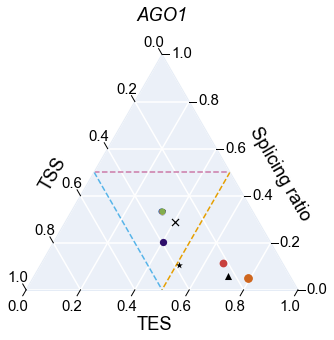

In [176]:
# WTC11 
plot_simplex_here(ca, 'AGO1', 'figures/')

figures//simplex_hdac4_centroid_vs_sample.pdf


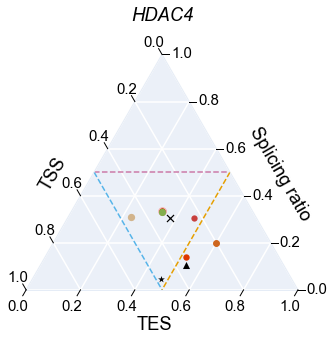

In [177]:
plot_simplex_here(ca, 'HDAC4', 'figures/')

figures//simplex_fgf2_centroid_vs_sample.pdf


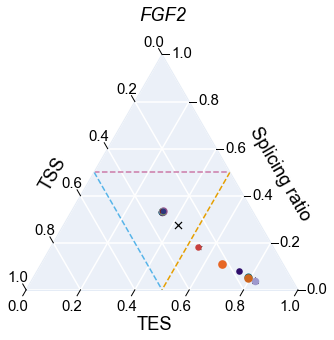

In [178]:
plot_simplex_here(ca, 'FGF2', 'figures/')

/Users/fairliereese/mortazavi_lab/documents/rnawg/dynamics//simplex_ctnnb1_centroid_vs_sample.pdf


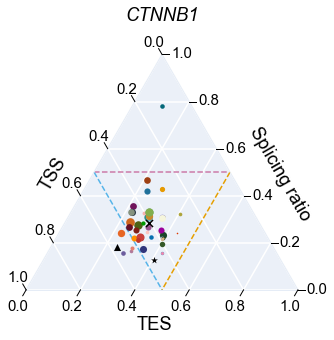

In [11]:
plot_simplex_here(ca, 'CTNNB1', dyn_dir)

In [13]:
ca.triplets.loc[(ca.triplets.gname=='CTNNB1')&(ca.triplets.source=='sample_det_centroid')]


,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
4110,sample_det_centroid,ENSG00000168036,NaN,NaN,NaN,11.74,NaN,0.405801,0.309722,0.284477,CTNNB1,NaN,NaN,mixed,ENSG00000168036,protein_coding


In [4]:
ca.triplets.loc[(ca.triplets.gname=='CTNNB1')&(ca.triplets.source=='sample_det')&(ca.triplets['sample'].isin(['caco2', 'mcf10a']))]


,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm
8177,sample_det,ENSG00000168036,7.0,4.0,17.0,19.0,3.090909,0.496774,0.283871,0.219355,CTNNB1,caco2,124.906631
38564,sample_det,ENSG00000168036,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,CTNNB1,mcf10a,76.340820


In [14]:
ca.triplets.loc[(ca.triplets.gname=='CTNNB1')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='splicing')]


,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
38564,sample_det,ENSG00000168036,1.0,1.0,7.0,7.0,7.0,0.111111,0.111111,0.777778,CTNNB1,mcf10a,76.34082,splicing,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2025: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:2024: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


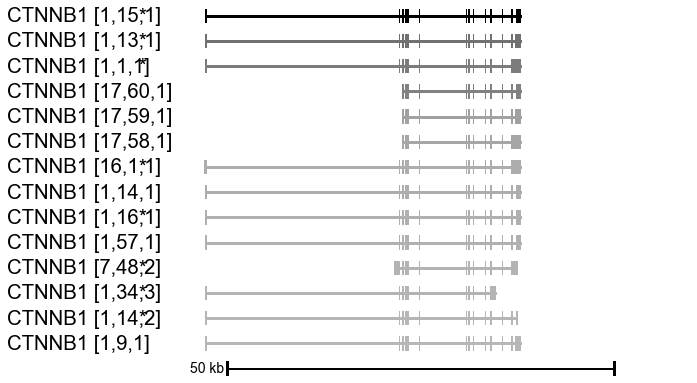

In [8]:
gene = 'CTNNB1'
obs_col = 'sample'
obs_condition = 'k562'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2)
fname = '{}{}_{}_isos_browser.pdf'.format(dyn_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


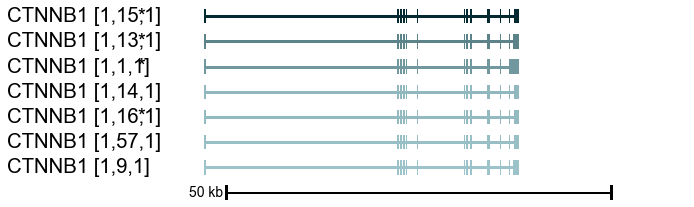

In [9]:
gene = 'CTNNB1'
obs_col = 'sample'
obs_condition = 'mcf10a'
light_shade = '#9bc3c9'
dark_shade= '#022a30'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40',
                              light_shade=light_shade, dark_shade=dark_shade)
fname = '{}{}_{}_isos_browser.pdf'.format(dyn_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)

In [7]:
light_shade = '#ffdeb3'
dark_shade = '#804800'
cmap = mpl.colors.LinearSegmentedColormap.from_list('', [light_shade, dark_shade])
# print(cmap)
# print(cmap(50))

cmap = plt.get_cmap('magma')[0]
print(cmap)


TypeError: 'ListedColormap' object is not subscriptable

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1854: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1853: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


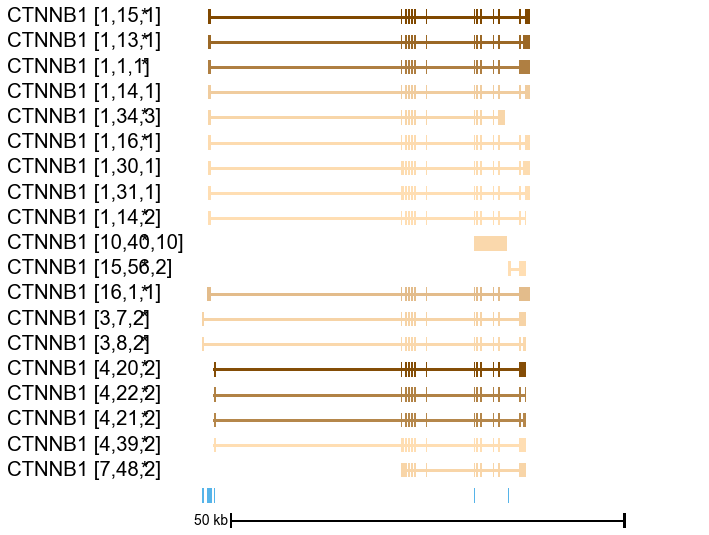

In [6]:
gene = 'CTNNB1'
obs_col = 'sample'
obs_condition = 'caco2'
light_shade = '#ffdeb3'
dark_shade = '#804800'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40',
                             add_tss=True, order='tss',
                             light_shade=light_shade, 
                             dark_shade=dark_shade)

fname = '{}{}_{}_isos_browser.pdf'.format(dyn_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)

In [17]:
df.head()

,source_obs_major,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,...,n_iso_obs_det,splicing_ratio_obs_det,tss_ratio_obs_det,tes_ratio_obs_det,spl_ratio_obs_det,gname_obs_det,sample_obs_det,gene_tpm_obs_det,sector_obs_det,dist
0,obs_major,ENSG00000000003,1.0,5.0,5.0,12.0,1.666667,0.130435,0.652174,0.217391,...,28.0,2.571429,0.104478,0.626866,0.268657,TSPAN6,NaN,NaN,tes,0.046883
1,obs_major,ENSG00000000005,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,...,1.0,1.000000,0.333333,0.333333,0.333333,TNMD,NaN,NaN,simple,0.000000
2,obs_major,ENSG00000000419,2.0,3.0,8.0,10.0,3.200000,0.243902,0.365854,0.390244,...,15.0,3.000000,0.222222,0.444444,0.333333,DPM1,NaN,NaN,mixed,0.057280
3,obs_major,ENSG00000000457,1.0,3.0,3.0,5.0,1.500000,0.181818,0.545455,0.272727,...,7.0,1.428571,0.355932,0.474576,0.169492,SCYL3,NaN,NaN,mixed,0.147188
4,obs_major,ENSG00000000460,2.0,4.0,6.0,10.0,2.000000,0.250000,0.500000,0.250000,...,15.0,2.000000,0.333333,0.444444,0.222222,C1orf112,NaN,NaN,mixed,0.064905


In [16]:
ca.triplets.loc[(ca.triplets.gname=='CTNNB1')&(ca.triplets.source=='sample_det')].head()


,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
8177,sample_det,ENSG00000168036,7.0,4.0,17.0,19.0,3.090909,0.496774,0.283871,0.219355,CTNNB1,caco2,124.906631,mixed,NaN,NaN
22716,sample_det,ENSG00000168036,7.0,4.0,12.0,13.0,2.181818,0.531034,0.303448,0.165517,CTNNB1,brain,59.088123,tss,NaN,NaN
38564,sample_det,ENSG00000168036,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,CTNNB1,mcf10a,76.340820,splicing,NaN,NaN
50740,sample_det,ENSG00000168036,3.0,4.0,8.0,8.0,2.285714,0.323077,0.430769,0.246154,CTNNB1,a673,42.351189,mixed,NaN,NaN
65512,sample_det,ENSG00000168036,10.0,5.0,21.0,22.0,2.800000,0.561798,0.280899,0.157303,CTNNB1,lung,77.363838,tss,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


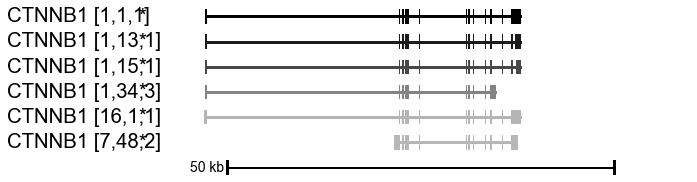

In [17]:
gene = 'CTNNB1'
obs_col = 'sample'
obs_condition = 'hl60'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


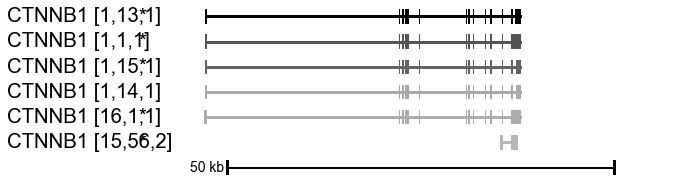

In [18]:
gene = 'CTNNB1'
obs_col = 'sample'
obs_condition = 'calu3'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


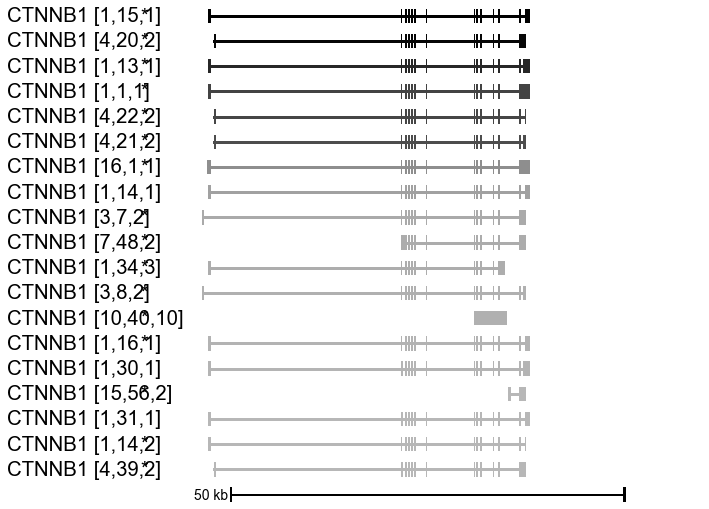

In [20]:
ca.triplets.loc[(ca.triplets.gname=='CTNNB1')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='tss')].head()
ca.triplets.loc[(ca.triplets.gname=='CTNNB1')&(ca.triplets.source=='sample_det')].sort_values(by='tss_ratio', ascending=False)

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
65512,sample_det,ENSG00000168036,10.0,5.0,21.0,22.0,2.800000,0.561798,0.280899,0.157303,CTNNB1,lung,77.363838,tss,NaN,NaN
22716,sample_det,ENSG00000168036,7.0,4.0,12.0,13.0,2.181818,0.531034,0.303448,0.165517,CTNNB1,brain,59.088123,tss,NaN,NaN
232956,sample_det,ENSG00000168036,7.0,3.0,16.0,17.0,3.200000,0.530303,0.227273,0.242424,CTNNB1,h1,223.842484,tss,NaN,NaN
216885,sample_det,ENSG00000168036,7.0,4.0,13.0,14.0,2.363636,0.523810,0.299320,0.176871,CTNNB1,vessels,65.838089,tss,NaN,NaN
8177,sample_det,ENSG00000168036,7.0,4.0,17.0,19.0,3.090909,0.496774,0.283871,0.219355,CTNNB1,caco2,124.906631,mixed,NaN,NaN
599056,sample_det,ENSG00000168036,6.0,3.0,15.0,16.0,3.333333,0.486486,0.243243,0.270270,CTNNB1,hepg2,174.510132,mixed,NaN,NaN
395946,sample_det,ENSG00000168036,8.0,5.0,23.0,26.0,3.538462,0.483721,0.302326,0.213953,CTNNB1,heart,84.519890,mixed,NaN,NaN
626145,sample_det,ENSG00000168036,7.0,5.0,15.0,16.0,2.500000,0.482759,0.344828,0.172414,CTNNB1,kidney,196.993683,mixed,NaN,NaN
310823,sample_det,ENSG00000168036,6.0,3.0,16.0,18.0,3.555556,0.477876,0.238938,0.283186,CTNNB1,wtc11,434.917236,mixed,NaN,NaN
258876,sample_det,ENSG00000168036,6.0,4.0,14.0,16.0,2.800000,0.468750,0.312500,0.218750,CTNNB1,ovary,83.643082,mixed,NaN,NaN


figures/simplex_psmg1_centroid_vs_sample.pdf


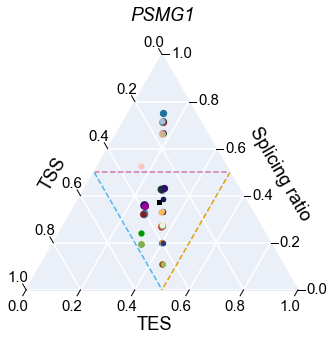

In [87]:
plot_simplex_here(ca, 'PSMG1')

figures/simplex_dus1l_centroid_vs_sample.pdf


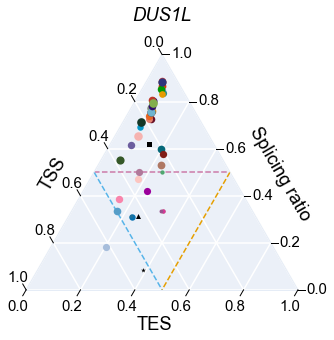

In [79]:
plot_simplex_here(ca, 'DUS1L')

In [82]:
ca.triplets.loc[(ca.triplets.gname=='DUS1L')&(ca.triplets.source=='sample_det')&(ca.triplets.sector.isin(['mixed', 'tss']))]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
22993,sample_det,ENSG00000169718,4.0,2.0,18.0,18.0,6.000000,0.333333,0.166667,0.500000,DUS1L,brain,98.011551,mixed,NaN,NaN
169705,sample_det,ENSG00000169718,2.0,1.0,2.0,2.0,1.333333,0.461538,0.230769,0.307692,DUS1L,liver,4.074787,mixed,NaN,NaN
203325,sample_det,ENSG00000169718,3.0,1.0,4.0,4.0,2.000000,0.500000,0.166667,0.333333,DUS1L,hl60_m2_24hr,146.542313,mixed,NaN,NaN
323742,sample_det,ENSG00000169718,3.0,2.0,9.0,9.0,3.600000,0.348837,0.232558,0.418605,DUS1L,huvec,94.916023,mixed,NaN,NaN
334305,sample_det,ENSG00000169718,2.0,1.0,4.0,4.0,2.666667,0.352941,0.176471,0.470588,DUS1L,hl60_m1_12hr,95.299568,mixed,NaN,NaN
360068,sample_det,ENSG00000169718,2.0,1.0,2.0,2.0,1.333333,0.461538,0.230769,0.307692,DUS1L,hl60_m2_72hr,47.445251,mixed,NaN,NaN
411827,sample_det,ENSG00000169718,2.0,1.0,2.0,2.0,1.333333,0.461538,0.230769,0.307692,DUS1L,pgp1,7.956586,mixed,NaN,NaN
423384,sample_det,ENSG00000169718,6.0,2.0,7.0,7.0,1.750000,0.615385,0.205128,0.179487,DUS1L,hl60_m2_12hr,96.387802,tss,NaN,NaN
447072,sample_det,ENSG00000169718,1.0,1.0,2.0,2.0,2.000000,0.250000,0.250000,0.500000,DUS1L,pgp1_endo,11.335737,mixed,NaN,NaN
481029,sample_det,ENSG00000169718,3.0,1.0,5.0,5.0,2.500000,0.461538,0.153846,0.384615,DUS1L,hl60_m1_24hr,116.930038,mixed,NaN,NaN


In [84]:
ca.triplets.loc[(ca.triplets.gname=='DUS1L')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='splicing')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
8405,sample_det,ENSG00000169718,2.0,1.0,14.0,14.0,9.333333,0.162162,0.081081,0.756757,DUS1L,caco2,159.585571,splicing,NaN,NaN
38781,sample_det,ENSG00000169718,2.0,2.0,12.0,12.0,6.000000,0.200000,0.200000,0.600000,DUS1L,mcf10a,155.927765,splicing,NaN,NaN
50968,sample_det,ENSG00000169718,1.0,1.0,13.0,13.0,13.000000,0.066667,0.066667,0.866667,DUS1L,a673,172.441620,splicing,NaN,NaN
65805,sample_det,ENSG00000169718,4.0,1.0,20.0,20.0,8.000000,0.307692,0.076923,0.615385,DUS1L,lung,118.290329,splicing,NaN,NaN
94061,sample_det,ENSG00000169718,5.0,1.0,22.0,22.0,7.333333,0.375000,0.075000,0.550000,DUS1L,colon,254.637833,splicing,NaN,NaN
108359,sample_det,ENSG00000169718,1.0,1.0,11.0,11.0,11.000000,0.076923,0.076923,0.846154,DUS1L,hmec,116.322990,splicing,NaN,NaN
120299,sample_det,ENSG00000169718,2.0,1.0,18.0,18.0,12.000000,0.133333,0.066667,0.800000,DUS1L,k562,233.207153,splicing,NaN,NaN
133454,sample_det,ENSG00000169718,2.0,1.0,12.0,12.0,8.000000,0.181818,0.090909,0.727273,DUS1L,imr90,136.057236,splicing,NaN,NaN
146211,sample_det,ENSG00000169718,1.0,1.0,10.0,10.0,10.000000,0.083333,0.083333,0.833333,DUS1L,pgp1_astro,97.889488,splicing,NaN,NaN
181092,sample_det,ENSG00000169718,2.0,2.0,9.0,9.0,4.500000,0.235294,0.235294,0.529412,DUS1L,pc9,166.472885,splicing,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


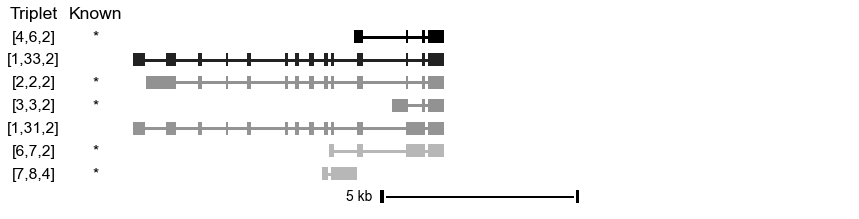

In [85]:
gene = 'DUS1L'
obs_col = 'sample'
obs_condition = 'hl60_m2_12hr'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


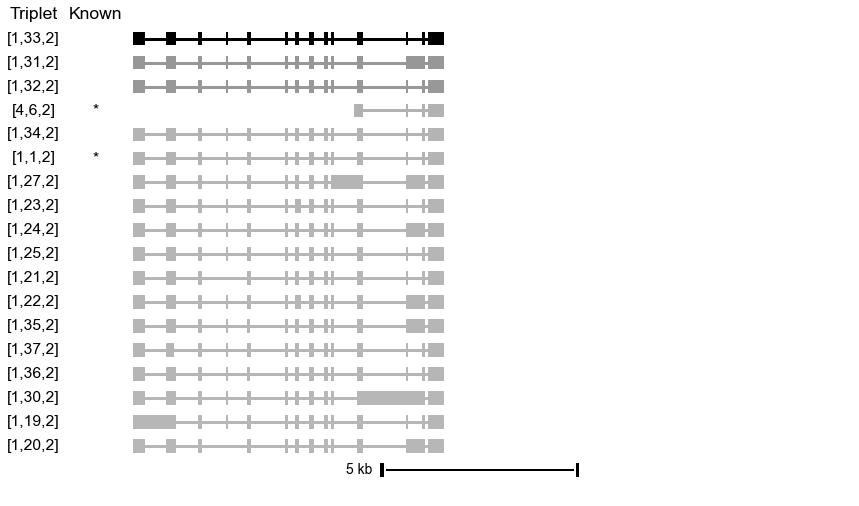

In [86]:
gene = 'DUS1L'
obs_col = 'sample'
obs_condition = 'k562'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

/Users/fairliereese/mortazavi_lab/documents/rnawg/fig3//simplex_akap8l_centroid_vs_sample.pdf


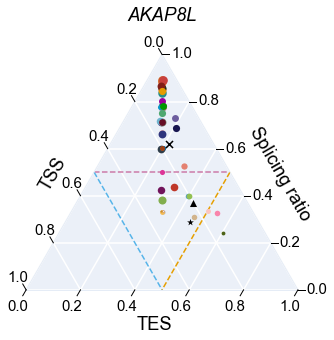

In [13]:
plot_simplex_here(ca, 'AKAP8L', fig_dir)

In [74]:
ca.triplets.loc[(ca.triplets.gname=='AKAP8L')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='splicing')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
199,sample_det,ENSG00000011243,1.0,1.0,11.0,11.0,11.000000,0.076923,0.076923,0.846154,AKAP8L,caco2,93.390732,splicing,NaN,NaN
13431,sample_det,ENSG00000011243,1.0,1.0,16.0,16.0,16.000000,0.055556,0.055556,0.888889,AKAP8L,brain,99.171486,splicing,NaN,NaN
31162,sample_det,ENSG00000011243,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,AKAP8L,mcf10a,70.682961,splicing,NaN,NaN
42923,sample_det,ENSG00000011243,1.0,1.0,12.0,12.0,12.000000,0.071429,0.071429,0.857143,AKAP8L,a673,100.674332,splicing,NaN,NaN
55766,sample_det,ENSG00000011243,1.0,2.0,12.0,12.0,8.000000,0.090909,0.181818,0.727273,AKAP8L,lung,47.650883,splicing,NaN,NaN
84631,sample_det,ENSG00000011243,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,AKAP8L,colon,55.193920,splicing,NaN,NaN
100579,sample_det,ENSG00000011243,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,AKAP8L,hmec,57.099216,splicing,NaN,NaN
112875,sample_det,ENSG00000011243,1.0,1.0,5.0,5.0,5.000000,0.142857,0.142857,0.714286,AKAP8L,k562,82.274010,splicing,NaN,NaN
137997,sample_det,ENSG00000011243,1.0,1.0,10.0,10.0,10.000000,0.083333,0.083333,0.833333,AKAP8L,pgp1_astro,166.707916,splicing,NaN,NaN
150909,sample_det,ENSG00000011243,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,AKAP8L,h9_de,14.262514,splicing,NaN,NaN


In [76]:
ca.triplets.loc[(ca.triplets.gname=='AKAP8L')&(ca.triplets.source=='sample_det')&(ca.triplets.sector.isin(['tes', 'splicing']))]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
199,sample_det,ENSG00000011243,1.0,1.0,11.0,11.0,11.000000,0.076923,0.076923,0.846154,AKAP8L,caco2,93.390732,splicing,NaN,NaN
13431,sample_det,ENSG00000011243,1.0,1.0,16.0,16.0,16.000000,0.055556,0.055556,0.888889,AKAP8L,brain,99.171486,splicing,NaN,NaN
31162,sample_det,ENSG00000011243,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,AKAP8L,mcf10a,70.682961,splicing,NaN,NaN
42923,sample_det,ENSG00000011243,1.0,1.0,12.0,12.0,12.000000,0.071429,0.071429,0.857143,AKAP8L,a673,100.674332,splicing,NaN,NaN
55766,sample_det,ENSG00000011243,1.0,2.0,12.0,12.0,8.000000,0.090909,0.181818,0.727273,AKAP8L,lung,47.650883,splicing,NaN,NaN
84631,sample_det,ENSG00000011243,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,AKAP8L,colon,55.193920,splicing,NaN,NaN
100579,sample_det,ENSG00000011243,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,AKAP8L,hmec,57.099216,splicing,NaN,NaN
112875,sample_det,ENSG00000011243,1.0,1.0,5.0,5.0,5.000000,0.142857,0.142857,0.714286,AKAP8L,k562,82.274010,splicing,NaN,NaN
137997,sample_det,ENSG00000011243,1.0,1.0,10.0,10.0,10.000000,0.083333,0.083333,0.833333,AKAP8L,pgp1_astro,166.707916,splicing,NaN,NaN
150909,sample_det,ENSG00000011243,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,AKAP8L,h9_de,14.262514,splicing,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


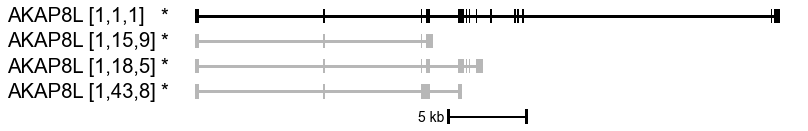

In [7]:
gene = 'AKAP8L'
obs_col = 'sample'
obs_condition = 'h9_panc_progen'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')
fname = 'figures/{}_{}_major_isos_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)
fname = '{}{}_{}_major_isos_browser.pdf'.format(fig_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


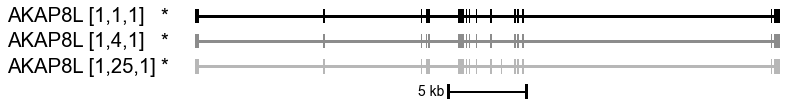

In [8]:
gene = 'AKAP8L'
obs_col = 'sample'
obs_condition = 'h9'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')
fname = 'figures/{}_{}_major_isos_browser.pdf'.format(gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)
fname = '{}{}_{}_major_isos_browser.pdf'.format(fig_dir, gene.lower(), obs_condition)
plt.savefig(fname, dpi=500)

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


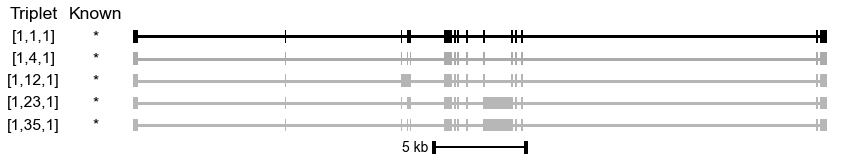

In [88]:
gene = 'AKAP8L'
obs_col = 'sample'
obs_condition = 'panc1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

figures/simplex_dennd10_centroid_vs_sample.pdf


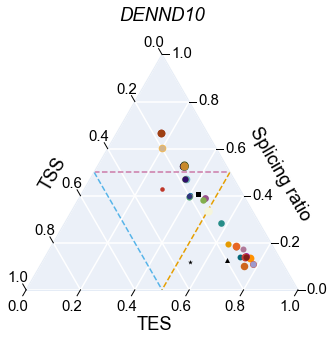

In [66]:
plot_simplex_here(ca, 'DENND10')

In [67]:
ca.triplets.loc[(ca.triplets.gname=='DENND10')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='splicing')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
59823,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,lung,36.239338,splicing,NaN,NaN
76873,sample_det,ENSG00000119979,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,DENND10,hl60_m0,33.492359,splicing,NaN,NaN
88447,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,colon,42.970890,splicing,NaN,NaN
128977,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,imr90,70.611984,splicing,NaN,NaN
154094,sample_det,ENSG00000119979,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,DENND10,h9_de,85.971825,splicing,NaN,NaN
188408,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,h9_panc_progen,111.968460,splicing,NaN,NaN
199602,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,hl60_m2_24hr,36.769863,splicing,NaN,NaN
241488,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,h9_neural_crest,147.503677,splicing,NaN,NaN
253722,sample_det,ENSG00000119979,1.0,2.0,5.0,5.0,3.333333,0.157895,0.315789,0.526316,DENND10,ovary,76.088303,splicing,NaN,NaN
283025,sample_det,ENSG00000119979,1.0,1.0,4.0,4.0,4.000000,0.166667,0.166667,0.666667,DENND10,muscle,13.796877,splicing,NaN,NaN


In [68]:
ca.triplets.loc[(ca.triplets.gname=='DENND10')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='tes')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
3613,sample_det,ENSG00000119979,1.0,7.0,5.0,16.0,1.250000,0.108108,0.756757,0.135135,DENND10,caco2,93.265884,tes,NaN,NaN
17280,sample_det,ENSG00000119979,1.0,6.0,5.0,15.0,1.428571,0.118644,0.711864,0.169492,DENND10,brain,40.148014,tes,NaN,NaN
34322,sample_det,ENSG00000119979,1.0,5.0,3.0,7.0,1.000000,0.142857,0.714286,0.142857,DENND10,mcf10a,38.857346,tes,NaN,NaN
46257,sample_det,ENSG00000119979,1.0,7.0,4.0,15.0,1.000000,0.111111,0.777778,0.111111,DENND10,a673,57.234642,tes,NaN,NaN
103833,sample_det,ENSG00000119979,1.0,7.0,4.0,11.0,1.000000,0.111111,0.777778,0.111111,DENND10,hmec,47.332588,tes,NaN,NaN
141371,sample_det,ENSG00000119979,1.0,4.0,5.0,9.0,2.000000,0.142857,0.571429,0.285714,DENND10,pgp1_astro,51.440231,tes,NaN,NaN
176556,sample_det,ENSG00000119979,1.0,5.0,4.0,8.0,1.333333,0.136364,0.681818,0.181818,DENND10,pc9,44.798008,tes,NaN,NaN
227824,sample_det,ENSG00000119979,1.0,5.0,4.0,13.0,1.333333,0.136364,0.681818,0.181818,DENND10,h1,86.473579,tes,NaN,NaN
305811,sample_det,ENSG00000119979,1.0,5.0,2.0,10.0,0.666667,0.150000,0.750000,0.100000,DENND10,wtc11,80.065025,tes,NaN,NaN
319242,sample_det,ENSG00000119979,1.0,6.0,4.0,10.0,1.142857,0.122807,0.736842,0.140351,DENND10,huvec,55.345387,tes,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


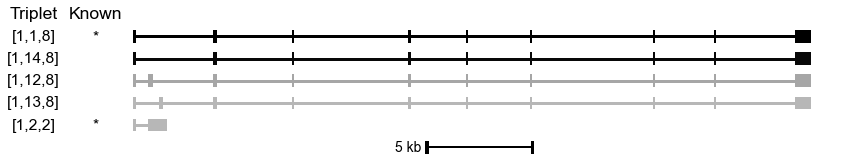

In [69]:
gene = 'DENND10'
obs_col = 'sample'
obs_condition = 'pgp1'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


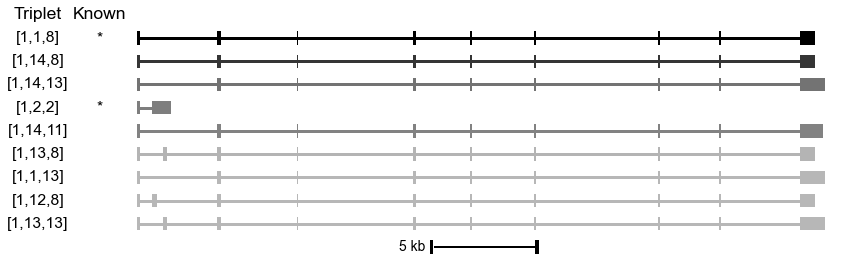

In [70]:
gene = 'DENND10'
obs_col = 'sample'
obs_condition = 'pgp1_astro'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


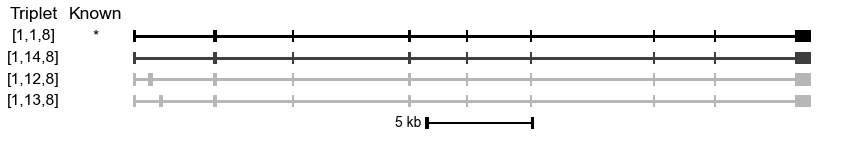

In [71]:
gene = 'DENND10'
obs_col = 'sample'
obs_condition = 'h9'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


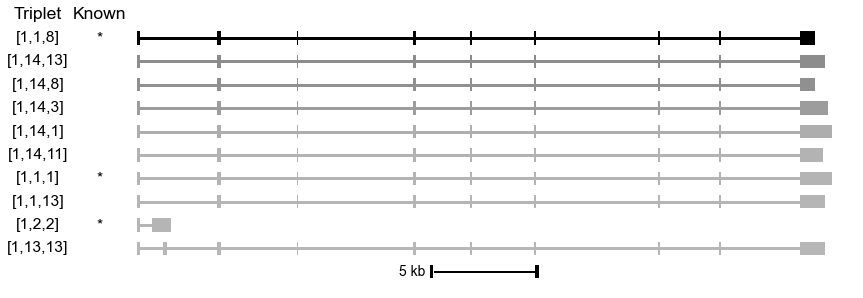

In [72]:
gene = 'DENND10'
obs_col = 'sample'
obs_condition = 'h9_chondro'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

figures/simplex_ggt1_centroid_vs_sample.pdf


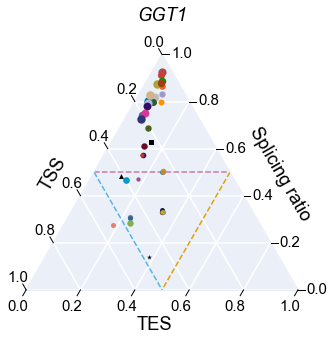

In [26]:
plot_simplex_here(ca, 'GGT1')

In [42]:
ca.triplets.loc[(ca.triplets.gname=='GGT1')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='tss')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
209611,sample_det,ENSG00000100031,3.0,1.0,3.0,3.0,1.5,0.545455,0.181818,0.272727,GGT1,vessels,4.894183,tss,NaN,NaN


In [48]:
ca.triplets.loc[(ca.triplets.gname=='GGT1')&(ca.triplets.source=='sample_det')&(ca.triplets['sample']=='imr90')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
127062,sample_det,ENSG00000100031,2.0,1.0,7.0,7.0,4.666667,0.26087,0.130435,0.608696,GGT1,imr90,18.944679,splicing,NaN,NaN


In [45]:
gene = 'GGT1'
obs_col = 'sample'
obs_condition = 'vessels'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

TypeError: plot_browser_isos() missing 1 required positional argument: 'major_set'

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


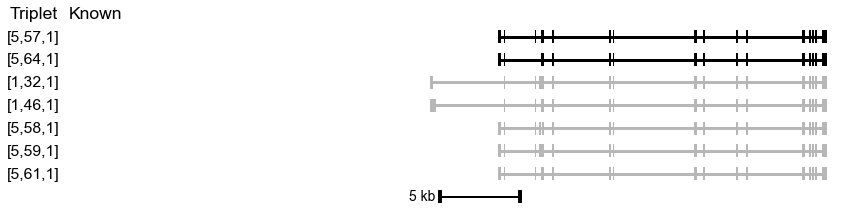

In [47]:
# don't like that all of these are novel
gene = 'GGT1'
obs_col = 'sample'
obs_condition = 'imr90'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

In [49]:
ca.triplets.loc[(ca.triplets.gname=='GGT1')&(ca.triplets.source=='sample_det')&(ca.triplets['sample']=='heart')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
388080,sample_det,ENSG00000100031,2.0,1.0,6.0,6.0,4.0,0.285714,0.142857,0.571429,GGT1,heart,2.501597,splicing,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


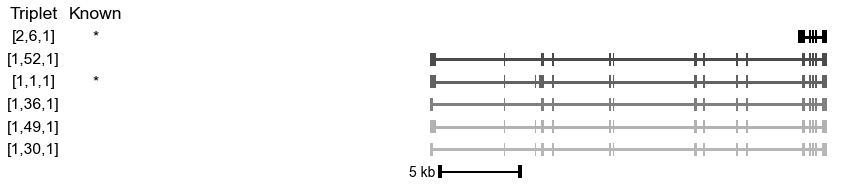

In [50]:
gene = 'GGT1'
obs_col = 'sample'
obs_condition = 'heart'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

figures/simplex_fgf2_centroid_vs_sample.pdf


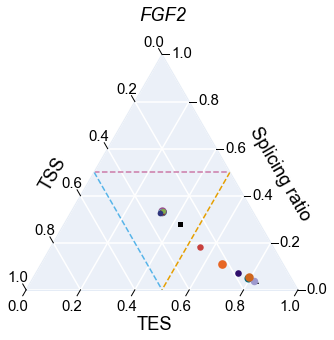

In [27]:
plot_simplex_here(ca, 'FGF2')

In [53]:
ca.triplets.loc[(ca.triplets.gname=='FGF2')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='simple')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
19347,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,brain,5.491330,simple,NaN,NaN
48010,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,a673,5.437787,simple,NaN,NaN
62005,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,lung,2.751375,simple,NaN,NaN
90501,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,colon,7.120934,simple,NaN,NaN
130644,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,imr90,39.611603,simple,NaN,NaN
143169,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,pgp1_astro,15.765527,simple,NaN,NaN
213769,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,vessels,9.584493,simple,NaN,NaN
255726,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,ovary,4.794230,simple,NaN,NaN
320922,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,huvec,8.885748,simple,NaN,NaN
368437,sample_det,ENSG00000138685,1.0,1.0,1.0,1.0,1.0,0.333333,0.333333,0.333333,FGF2,calu3,19.401451,simple,NaN,NaN


In [54]:
ca.triplets.loc[(ca.triplets.gname=='FGF2')&(ca.triplets.source=='sample_det')&(ca.triplets.sector=='tes')]

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
36001,sample_det,ENSG00000138685,1.0,5.0,1.0,5.0,0.333333,0.157895,0.789474,0.052632,FGF2,mcf10a,83.353462,tes,NaN,NaN
105523,sample_det,ENSG00000138685,1.0,6.0,1.0,6.0,0.285714,0.137255,0.823529,0.039216,FGF2,hmec,41.009720,tes,NaN,NaN
117582,sample_det,ENSG00000138685,1.0,4.0,1.0,4.0,0.400000,0.185185,0.740741,0.074074,FGF2,k562,15.327695,tes,NaN,NaN
229799,sample_det,ENSG00000138685,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,FGF2,h1,163.024597,tes,NaN,NaN
307737,sample_det,ENSG00000138685,1.0,5.0,1.0,5.0,0.333333,0.157895,0.789474,0.052632,FGF2,wtc11,127.461510,tes,NaN,NaN
344145,sample_det,ENSG00000138685,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,FGF2,h1_de,13.169581,tes,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


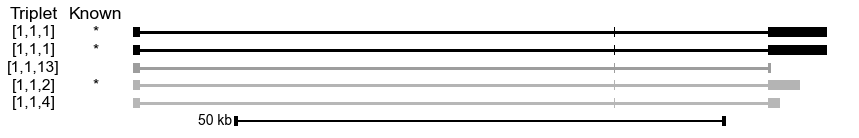

In [55]:
gene = 'FGF2'
obs_col = 'sample'
obs_condition = 'k562'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/plotting.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  norm_val = (entry[obs_condition]-tpm_df[obs_condition].min())/(tpm_df[obs_condition].max()-tpm_df[obs_condition].min())


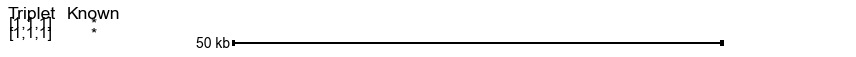

In [56]:
gene = 'FGF2'
obs_col = 'sample'
obs_condition = 'calu3'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                             obs_col, obs_condition,
                             filt_ab, major_set,
                             h=0.2, ref_source='v40')

figures/simplex_col3a1_centroid_vs_sample.pdf


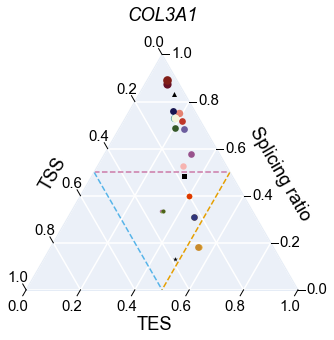

In [28]:
plot_simplex_here(ca, 'COL3A1')

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
38564,sample_det,ENSG00000168036,1.0,1.0,7.0,7.0,7.0,0.111111,0.111111,0.777778,CTNNB1,mcf10a,76.34082,splicing,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


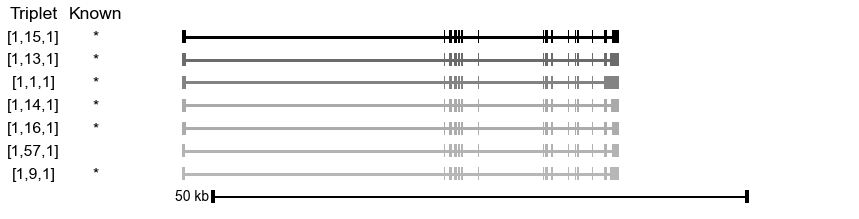

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
8177,sample_det,ENSG00000168036,7.0,4.0,17.0,19.0,3.090909,0.496774,0.283871,0.219355,CTNNB1,caco2,124.906631,mixed,NaN,NaN
22716,sample_det,ENSG00000168036,7.0,4.0,12.0,13.0,2.181818,0.531034,0.303448,0.165517,CTNNB1,brain,59.088123,tss,NaN,NaN
38564,sample_det,ENSG00000168036,1.0,1.0,7.0,7.0,7.000000,0.111111,0.111111,0.777778,CTNNB1,mcf10a,76.340820,splicing,NaN,NaN
50740,sample_det,ENSG00000168036,3.0,4.0,8.0,8.0,2.285714,0.323077,0.430769,0.246154,CTNNB1,a673,42.351189,mixed,NaN,NaN
65512,sample_det,ENSG00000168036,10.0,5.0,21.0,22.0,2.800000,0.561798,0.280899,0.157303,CTNNB1,lung,77.363838,tss,NaN,NaN


Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


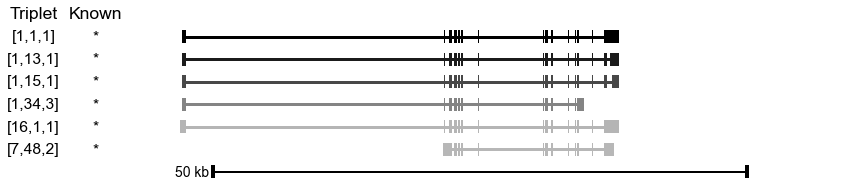

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


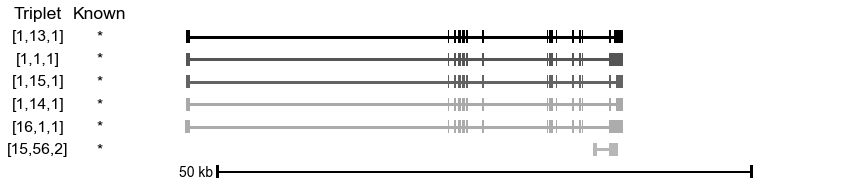

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1815: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
15.711947626841242
17.571194762684122


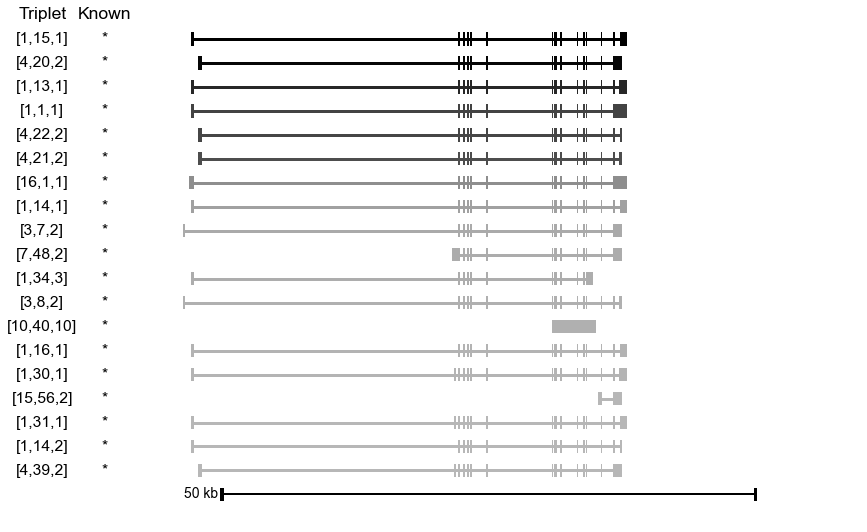

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,gname,sample,gene_tpm,sector,gid_stable,biotype
65512,sample_det,ENSG00000168036,10.0,5.0,21.0,22.0,2.800000,0.561798,0.280899,0.157303,CTNNB1,lung,77.363838,tss,NaN,NaN
22716,sample_det,ENSG00000168036,7.0,4.0,12.0,13.0,2.181818,0.531034,0.303448,0.165517,CTNNB1,brain,59.088123,tss,NaN,NaN
232956,sample_det,ENSG00000168036,7.0,3.0,16.0,17.0,3.200000,0.530303,0.227273,0.242424,CTNNB1,h1,223.842484,tss,NaN,NaN
216885,sample_det,ENSG00000168036,7.0,4.0,13.0,14.0,2.363636,0.523810,0.299320,0.176871,CTNNB1,vessels,65.838089,tss,NaN,NaN
8177,sample_det,ENSG00000168036,7.0,4.0,17.0,19.0,3.090909,0.496774,0.283871,0.219355,CTNNB1,caco2,124.906631,mixed,NaN,NaN
599056,sample_det,ENSG00000168036,6.0,3.0,15.0,16.0,3.333333,0.486486,0.243243,0.270270,CTNNB1,hepg2,174.510132,mixed,NaN,NaN
395946,sample_det,ENSG00000168036,8.0,5.0,23.0,26.0,3.538462,0.483721,0.302326,0.213953,CTNNB1,heart,84.519890,mixed,NaN,NaN
626145,sample_det,ENSG00000168036,7.0,5.0,15.0,16.0,2.500000,0.482759,0.344828,0.172414,CTNNB1,kidney,196.993683,mixed,NaN,NaN
310823,sample_det,ENSG00000168036,6.0,3.0,16.0,18.0,3.555556,0.477876,0.238938,0.283186,CTNNB1,wtc11,434.917236,mixed,NaN,NaN
258876,sample_det,ENSG00000168036,6.0,4.0,14.0,16.0,2.800000,0.468750,0.312500,0.218750,CTNNB1,ovary,83.643082,mixed,NaN,NaN
